## **Importing Libraries**

In [5]:
import os
from glob import glob
import random
import tensorflow
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings

import seaborn as sns 
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from keras import layers
from keras.applications.imagenet_utils import preprocess_input

from tensorflow import keras 
from keras import models
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

## **Functions**

In [8]:
NUMBER_CLASSES = 10

# Read with opencv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: #Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: #Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) #Reduce size
    return img

#Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = []
    train_labels = []
    #Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10) #categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    return x_train, x_test, y_train, y_test

def split_validation_set(train, target, test_size):
    random_state = 51
    X_train, X_test, y_train, y_test = \
        train_test_split(train, target,
                         test_size=test_size,
                         random_state=random_state)
    return X_train, X_test, y_train, y_test

#Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1, img_rows, img_cols, color_type)
    return test_data, test_ids

## **EDA**

In [11]:
path = "../input/state-farm-distracted-driver-detection/imgs/train/"

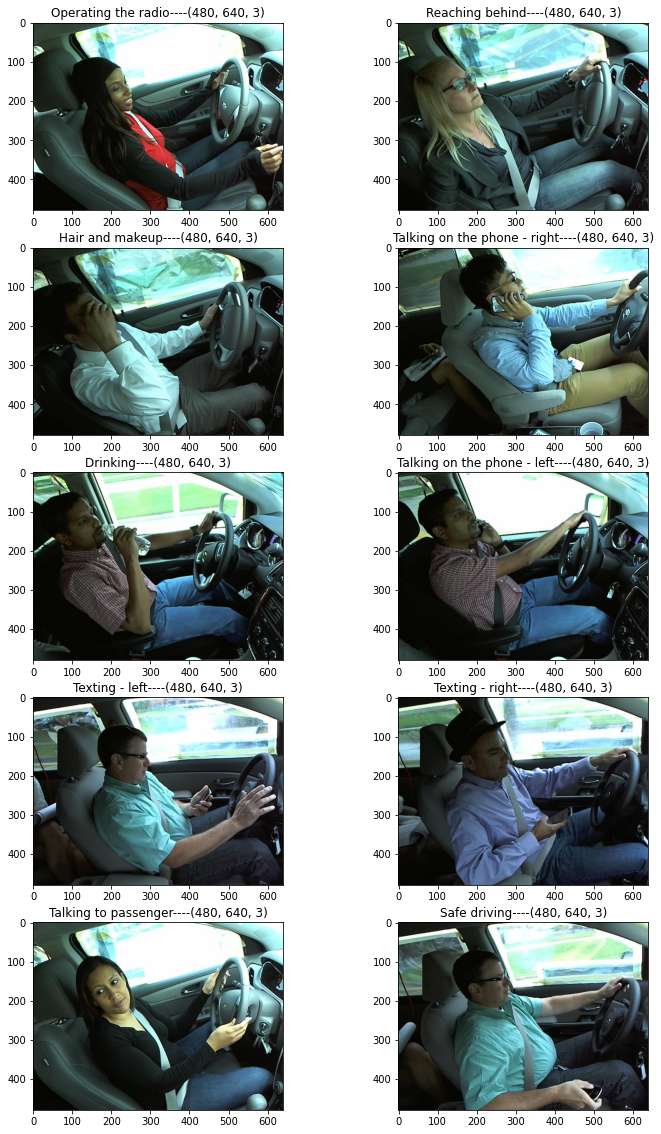

In [12]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1

for directory in os.listdir(path):
        for i, file in enumerate(os.listdir(path + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(path + directory + '/' + file)
                plt.imshow(image)
                plt.title(f"{activity_map[directory]}----{image.shape}")

In [13]:
data = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
data

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [14]:
import plotly.express as px

px.histogram(data, x="classname", color="classname", title="Number of images by categories ")

## **Baseline Dense layers model**

In [85]:
img_rows = 224
img_cols = 224
color_type = 1
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:09<01:22,  9.15s/it]

Loading directory c1


 20%|██        | 2/10 [00:18<01:12,  9.12s/it]

Loading directory c2


 30%|███       | 3/10 [00:27<01:02,  9.00s/it]

Loading directory c3


 40%|████      | 4/10 [00:35<00:53,  8.93s/it]

Loading directory c4


 50%|█████     | 5/10 [00:44<00:43,  8.77s/it]

Loading directory c5


 60%|██████    | 6/10 [00:52<00:34,  8.69s/it]

Loading directory c6


 70%|███████   | 7/10 [01:01<00:26,  8.67s/it]

Loading directory c7


 80%|████████  | 8/10 [01:08<00:16,  8.27s/it]

Loading directory c8


 90%|█████████ | 9/10 [01:16<00:07,  7.90s/it]

Loading directory c9


100%|██████████| 10/10 [01:23<00:00,  8.38s/it]


Train shape: (17939, 224, 224, 1)
17939 train samples


In [86]:
nb_test_samples = 200
img_rows = 224
img_cols = 224
color_type = 1
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 200/79726 [00:00<05:33, 238.64it/s]

Test shape: (200, 224, 224, 1)
200 Test samples


In [92]:
models_dir =  "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='/saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

In [87]:
def create_model_v0():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(224*224*1,)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dense(10, activation='softmax'))
    return model

In [88]:
model_v0 = create_model_v0()

# More details about the layers
model_v0.summary()

# Compiling the model
model_v0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               25690624  
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 25,856,138
Trainable params: 25,856,138
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Training the Dense Model version 1
history_v1 = model_v0.fit(x_train.reshape(17939,224*224*1), y_train, 
          validation_data=(x_test.reshape(4485,224*224*1), y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/6
281/281 [==============================] - 41s 146ms/step - loss: 5.4501 - accuracy: 0.8977 - val_loss: 7.3070 - val_accuracy: 0.8767

Epoch 00001: val_loss improved from inf to 7.30700, saving model to /saved_models/weights_best_vanilla.hdf5
Epoch 2/6
281/281 [==============================] - 41s 147ms/step - loss: 5.4971 - accuracy: 0.8974 - val_loss: 9.7709 - val_accuracy: 0.8410

Epoch 00002: val_loss did not improve from 7.30700
Epoch 3/6
281/281 [==============================] - 38s 135ms/step - loss: 4.3899 - accuracy: 0.9187 - val_loss: 8.0371 - val_accuracy: 0.8787

Epoch 00003: val_loss did not improve from 7.30700
Epoch 00003: early stopping


In [94]:
score = model_v0.evaluate(x_test.reshape(4485,224*224*1), y_test, verbose=1)
print('Score: ', score)

141/141 [==============================] - 4s 26ms/step - loss: 8.0371 - accuracy: 0.8787
Score:  [8.037109375, 0.8787068128585815]


In [95]:
model_v0.save('./')

In [96]:
model_v0.save_weights('./')

## **Baseline CNN model**

In [99]:
img_rows = 64 # dimension of images
img_cols = 64
color_type = 1 # grey
nb_test_samples = 200

# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:17<02:38, 17.56s/it]

Loading directory c1


 20%|██        | 2/10 [00:26<01:41, 12.71s/it]

Loading directory c2


 30%|███       | 3/10 [00:36<01:19, 11.38s/it]

Loading directory c3


 40%|████      | 4/10 [00:45<01:03, 10.56s/it]

Loading directory c4


 50%|█████     | 5/10 [00:55<00:50, 10.06s/it]

Loading directory c5


 60%|██████    | 6/10 [01:03<00:38,  9.64s/it]

Loading directory c6


 70%|███████   | 7/10 [01:12<00:28,  9.37s/it]

Loading directory c7


 80%|████████  | 8/10 [01:20<00:17,  8.86s/it]

Loading directory c8


 90%|█████████ | 9/10 [01:27<00:08,  8.20s/it]

Loading directory c9


100%|██████████| 10/10 [01:34<00:00,  9.45s/it]


In [100]:
# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 200/79726 [00:00<04:40, 283.11it/s]


In [107]:
batch_size = 64
nb_epoch = 6

In [108]:
# Using ImageDataGenerator from keras
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
#                                    shear_range = 0.2, 
#                                    zoom_range = 0.2, 
#                                    horizontal_flip = True, 
#                                    validation_split = 0.2
                                  )

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [109]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [110]:
model = Sequential()

## CNN 1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
model.add(BatchNormalization())

model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

## CNN 2
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

## CNN 3
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.5))

## Output
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,activation='softmax'))

In [111]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 31, 31, 64)       

In [112]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [113]:
history_v2 = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/6
281/281 [==============================] - 220s 771ms/step - loss: 1.5443 - accuracy: 0.4926 - val_loss: 0.4259 - val_accuracy: 0.8658
Epoch 2/6
281/281 [==============================] - 213s 757ms/step - loss: 0.4442 - accuracy: 0.8537 - val_loss: 0.1538 - val_accuracy: 0.9532
Epoch 3/6
281/281 [==============================] - 209s 745ms/step - loss: 0.2455 - accuracy: 0.9216 - val_loss: 0.0702 - val_accuracy: 0.9808
Epoch 4/6
281/281 [==============================] - 209s 745ms/step - loss: 0.1742 - accuracy: 0.9451 - val_loss: 0.0656 - val_accuracy: 0.9824
Epoch 5/6
281/281 [==============================] - 212s 755ms/step - loss: 0.1293 - accuracy: 0.9589 - val_loss: 0.0574 - val_accuracy: 0.9815
Epoch 6/6
281/281 [==============================] - 212s 755ms/step - loss: 0.0985 - accuracy: 0.9686 - val_loss: 0.0421 - val_accuracy: 0.9882


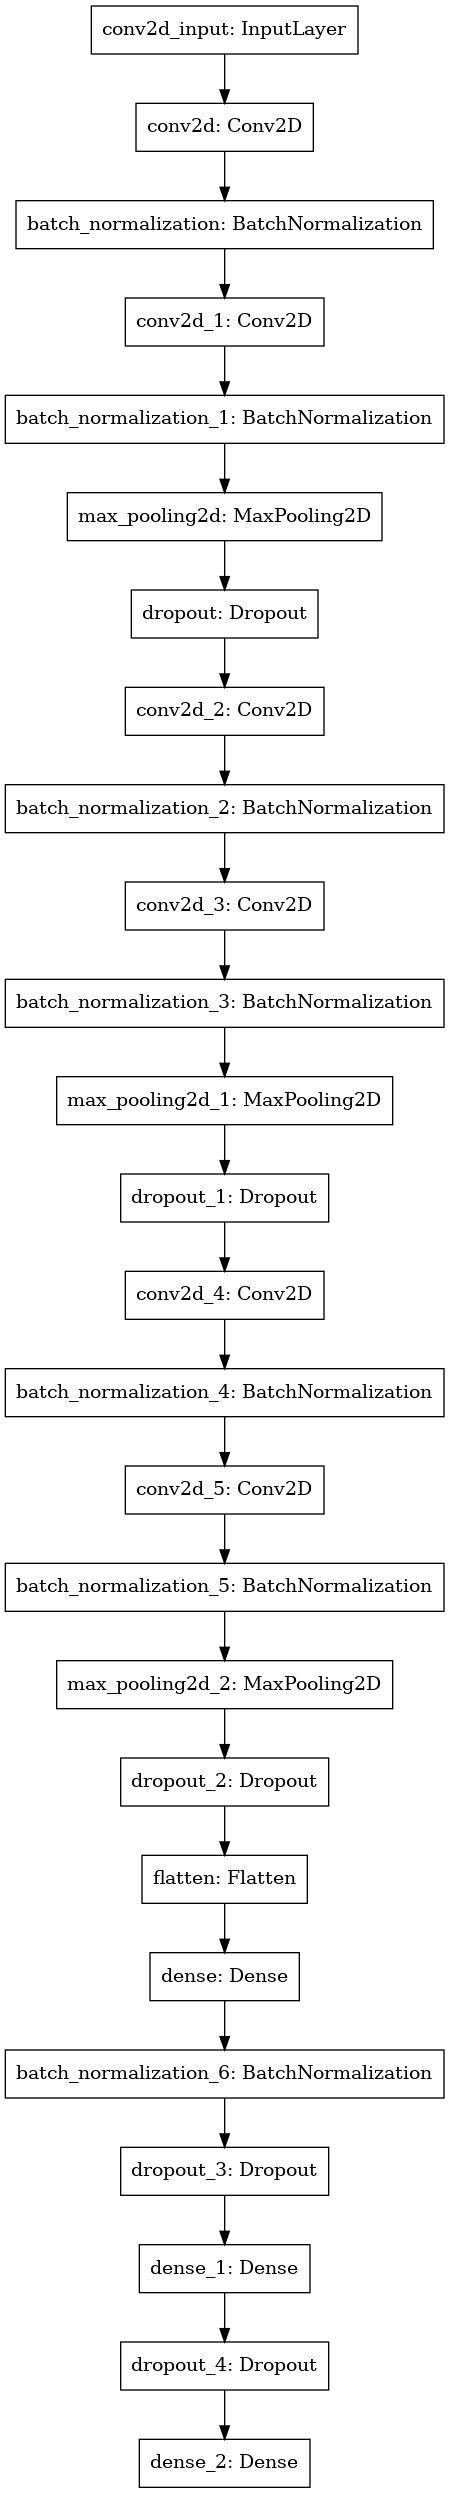

In [22]:
plot_model(model)

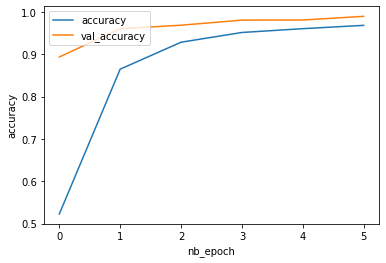

In [23]:
plt.plot(history_v2.history["accuracy"])
plt.plot(history_v2.history['val_accuracy'])

plt.ylabel('accuracy')
plt.xlabel('nb_epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

plt.show()

In [24]:
score1 = model.evaluate(x_test, y_test, verbose=1)
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

141/141 [==============================] - 15s 103ms/step - loss: 0.0351 - accuracy: 0.9897
Loss:  0.035131312906742096
Accuracy:  98.97435903549194  %


In [25]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

1/1 [==============================] - 0s 370ms/step
Y prediction: [[1.9079283e-09 8.7641758e-16 2.4082774e-11 5.5070032e-10 2.4784116e-10
  9.9999964e-01 3.3204529e-12 8.7869495e-10 9.7563579e-08 2.1145745e-07]]
Predicted: Operating the radio


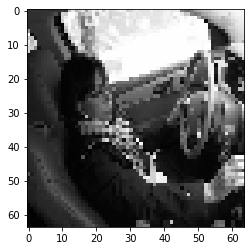

1/1 [==============================] - 0s 50ms/step
Y prediction: [[9.6494182e-07 1.5600721e-09 6.6973621e-07 4.2936104e-09 2.5467530e-06
  9.9985135e-01 4.9533831e-08 5.3989105e-08 1.6404088e-06 1.4281916e-04]]
Predicted: Operating the radio


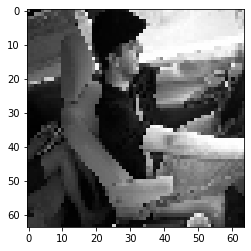

1/1 [==============================] - 0s 49ms/step
Y prediction: [[6.2608099e-01 1.5730865e-01 3.8803220e-02 2.8636013e-03 2.5035893e-05
  1.0395885e-05 3.4041263e-04 8.9968416e-05 5.9547266e-03 1.6852300e-01]]
Predicted: Safe driving


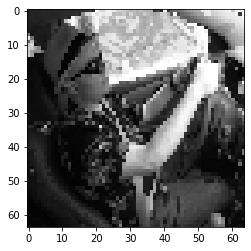

1/1 [==============================] - 0s 51ms/step
Y prediction: [[1.5194789e-06 6.5872609e-06 6.5887538e-03 6.2759011e-09 2.4896980e-07
  1.8446251e-08 2.3642656e-07 6.7874826e-06 9.9319708e-01 1.9877782e-04]]
Predicted: Hair and makeup


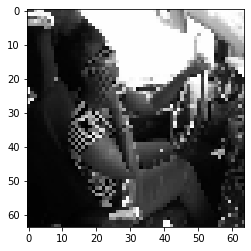

1/1 [==============================] - 0s 45ms/step
Y prediction: [[1.5350214e-03 1.5164029e-07 1.6971776e-06 5.8196956e-01 2.9925475e-01
  9.9514835e-02 1.1400979e-07 2.0523319e-06 3.2206574e-03 1.4501143e-02]]
Predicted: Texting - left


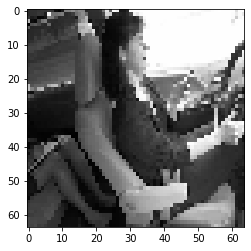

1/1 [==============================] - 0s 44ms/step
Y prediction: [[1.8554418e-08 4.3203863e-09 3.3244050e-12 9.9999905e-01 2.6613193e-07
  7.5633750e-07 1.8466301e-11 4.3471053e-11 2.0905873e-11 6.5141292e-10]]
Predicted: Texting - left


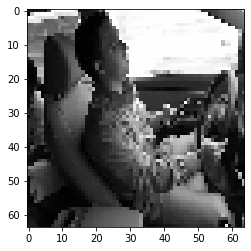

1/1 [==============================] - 0s 46ms/step
Y prediction: [[8.3152321e-05 6.0970462e-03 7.4275383e-03 2.8164373e-04 2.4728444e-05
  5.1567436e-04 1.8993655e-03 4.7209854e-03 7.7920413e-01 1.9974571e-01]]
Predicted: Hair and makeup


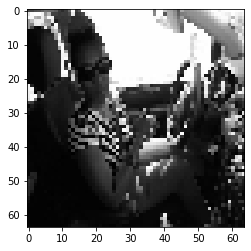

1/1 [==============================] - 0s 46ms/step
Y prediction: [[8.6212030e-04 8.4492385e-06 1.2355198e-06 3.0408602e-05 2.3270276e-07
  6.0492719e-04 1.2098376e-06 3.8381959e-06 1.9221451e-02 9.7926611e-01]]
Predicted: Talking to passenger


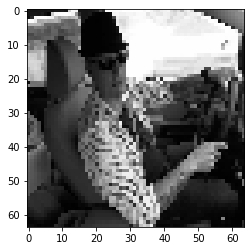

1/1 [==============================] - 0s 49ms/step
Y prediction: [[1.6232641e-06 2.8190902e-06 2.5090350e-02 3.1687233e-10 7.1662212e-06
  7.9280670e-07 9.7489017e-01 4.9105608e-09 7.0835295e-06 3.2163378e-08]]
Predicted: Drinking


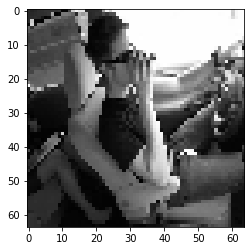

1/1 [==============================] - 0s 49ms/step
Y prediction: [[5.5082644e-08 7.8940366e-07 7.8171505e-09 8.1807713e-11 8.6182572e-09
  2.4353764e-07 8.5383385e-07 9.9999678e-01 9.9755539e-07 2.4239392e-07]]
Predicted: Reaching behind


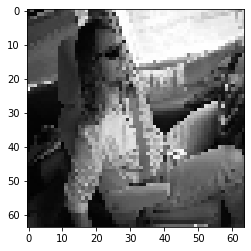

In [26]:
for i in range(10):
    plot_test_class(model, test_files, i)

In [35]:
model.save('./')

In [36]:
model.save_weights('./')

## **Data augmentation**

In [37]:
model_1 = load_model('./')

In [45]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [46]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [47]:
print(nb_train_samples)
print(nb_validation_samples)

17939
4485


In [58]:
history_v1 = model_1.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 10, 
                         verbose = 1,
                         callbacks=callbacks,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
280/280 [==============================] - 219s 781ms/step - loss: 0.2360 - accuracy: 0.9245 - val_loss: 0.1119 - val_accuracy: 0.9692
Epoch 2/10
280/280 [==============================] - 222s 793ms/step - loss: 0.2268 - accuracy: 0.9283 - val_loss: 0.0595 - val_accuracy: 0.9804
Epoch 3/10
280/280 [==============================] - 220s 786ms/step - loss: 0.2088 - accuracy: 0.9325 - val_loss: 0.1863 - val_accuracy: 0.9473
Epoch 4/10
280/280 [==============================] - 219s 781ms/step - loss: 0.1983 - accuracy: 0.9368 - val_loss: 0.0495 - val_accuracy: 0.9819
Epoch 5/10
280/280 [==============================] - 218s 778ms/step - loss: 0.1776 - accuracy: 0.9443 - val_loss: 0.0545 - val_accuracy: 0.9819
Epoch 6/10
280/280 [==============================] - 223s 796ms/step - loss: 0.1712 - accuracy: 0.9445 - val_loss: 0.0641 - val_accuracy: 0.9808
Epoch 7/10
280/280 [==============================] - 220s 786ms/step - loss: 0.1645 - accuracy: 0.9476 - val_loss: 0.0604 -

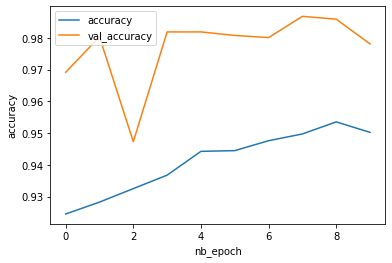

In [59]:
plt.plot(history_v1.history["accuracy"])
plt.plot(history_v1.history['val_accuracy'])

plt.ylabel('accuracy')
plt.xlabel('nb_epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

plt.show()

In [69]:
score2 = model_1.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print('Loss: ', score2[0])
print('Accuracy: ', score2[1]*100, ' %')

Loss:  0.06373465061187744
Accuracy:  97.81249761581421  %


In [63]:
model_1.save('./')

In [64]:
model_1.save_weights('./')